# Regression with a neural network in Keras

> This notebook is adapted from: https://www.tensorflow.org/tutorials/keras/regression

In this example we will use neural networks to predict numeric values this time, this task is called regression. In this case, we will have the well-known [MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg) which contains information on various different cars and their fuel consumption (target variable).

## Libraries

In [24]:
%reload_ext tensorboard
!rm -rf ./logs/

In [25]:
import pathlib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## The dataset

Let's download the dataset using the Keras utility module.

In [26]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

dataset_path


'/Users/felipe/.keras/datasets/auto-mpg.data'

Now we can use Pandas to load it.

In [27]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Pre-processing

Here we will do some baseic pre-processing in order to correct some gaps in the dataset. We drop observations with NA values and also convert some categorical columns into multiple columns (all input values to a neural network must be numeric).

In [28]:
print(dataset.isna().sum())

dataset = dataset.dropna()

# Convert categorical column to one-hot encoding, otherwise known as dummy variables
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Data exploration

Some basic data exploration is performed by visualizing a pair plot of features.

count         mean         std     min       25%     50%  \
Cylinders     392.0     5.471939    1.705783     3.0     4.000     4.0   
Displacement  392.0   194.411990  104.644004    68.0   105.000   151.0   
Horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
Weight        392.0  2977.584184  849.402560  1613.0  2225.250  2803.5   
Acceleration  392.0    15.541327    2.758864     8.0    13.775    15.5   
Model Year    392.0    75.979592    3.683737    70.0    73.000    76.0   
Europe        392.0     0.173469    0.379136     0.0     0.000     0.0   
Japan         392.0     0.201531    0.401656     0.0     0.000     0.0   
USA           392.0     0.625000    0.484742     0.0     0.000     1.0   

                   75%     max  
Cylinders        8.000     8.0  
Displacement   275.750   455.0  
Horsepower     126.000   230.0  
Weight        3614.750  5140.0  
Acceleration    17.025    24.8  
Model Year      79.000    82.0  
Europe           0.000     1.0  
Japan    

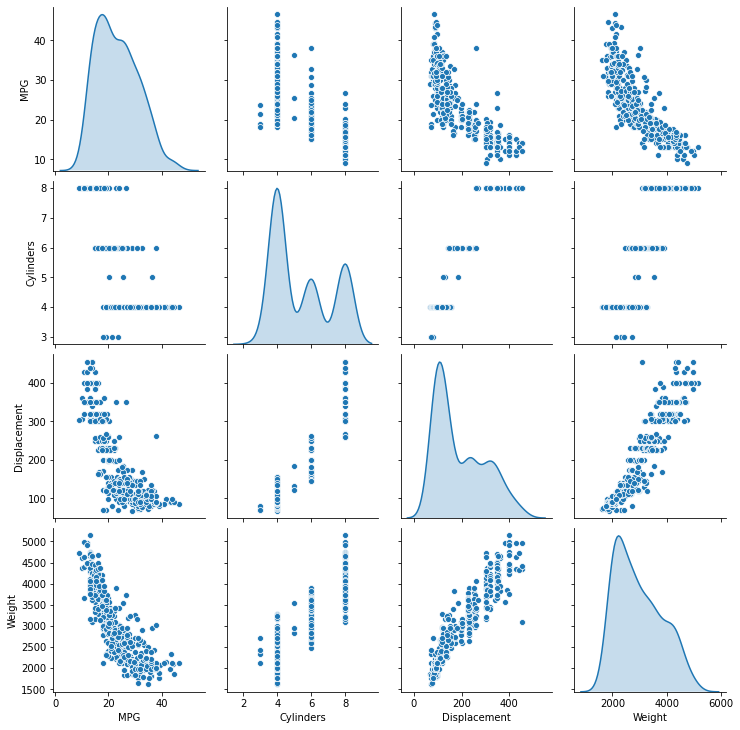

In [29]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

stats = dataset.describe()
stats.pop("MPG")
stats = stats.transpose()
print(stats)

## Splitting validation data

Now we will create 4 datasets with the train/validation split of features and target variables.

In [30]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_stats = train_dataset.describe().transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

train_dataset = norm(train_dataset)
test_dataset = norm(test_dataset)

print(train_dataset.head())
print(train_labels)

Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   

       Europe     Japan       USA  
146 -0.465148 -0.495225  0.774676  
282 -0.465148 -0.495225  0.774676  
69  -0.465148 -0.495225  0.774676  
378 -0.465148 -0.495225  0.774676  
331 -0.465148  2.012852 -1.286751  
146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64


## Building the model

Now, we build a model for a fully connected (dense) neural network.

In [31]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])

    return model

## Train

We train the model! Note that in order to perform a regression, our output neurons must have a linear activation function and MSE as loss.

In [32]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [37]:
model = build_model()

model.fit(train_dataset, train_labels, epochs=100, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)])

Train on 314 samples
Epoch 1/100
314/314 [==============================] - 0s 712us/sample - loss: 592.8281 - mae: 23.0927 - mse: 592.8281
Epoch 2/100
314/314 [==============================] - 0s 63us/sample - loss: 552.2297 - mae: 22.2466 - mse: 552.2298
Epoch 3/100
314/314 [==============================] - 0s 61us/sample - loss: 507.7958 - mae: 21.2664 - mse: 507.7958
Epoch 4/100
314/314 [==============================] - 0s 62us/sample - loss: 454.6932 - mae: 20.0580 - mse: 454.6932
Epoch 5/100
314/314 [==============================] - 0s 62us/sample - loss: 389.5295 - mae: 18.4434 - mse: 389.5295
Epoch 6/100
314/314 [==============================] - 0s 60us/sample - loss: 310.7134 - mae: 16.3217 - mse: 310.7134
Epoch 7/100
314/314 [==============================] - 0s 66us/sample - loss: 225.5250 - mae: 13.5707 - mse: 225.5249
Epoch 8/100
314/314 [==============================] - 0s 54us/sample - loss: 146.0759 - mae: 10.5462 - mse: 146.0759
Epoch 9/100
314/314 [=============

## Predictions and evaluation

Now, we can use the validation set to evaluate our predictions and then use the model.

In [34]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("MSE and MAE: {:5.2f}, {:5.2f} MPG".format(mse, mae))

78/78 - 0s - loss: 5.4520 - mae: 1.7623 - mse: 5.4520
MSE and MAE:  5.45,  1.76 MPG


In [35]:
model.predict(test_dataset)

array([[15.33536 ],
       [11.02807 ],
       [11.038052],
       [23.55368 ],
       [20.950546],
       [12.944635],
       [13.317501],
       [12.859867],
       [19.827938],
       [30.33084 ],
       [25.245628],
       [24.515331],
       [14.631443],
       [26.873331],
       [12.614977],
       [14.002535],
       [14.482203],
       [13.184034],
       [19.030573],
       [12.785109],
       [13.510076],
       [25.979336],
       [19.94873 ],
       [21.47702 ],
       [29.90884 ],
       [23.667793],
       [16.227077],
       [23.066547],
       [16.869465],
       [18.470985],
       [27.996998],
       [20.238571],
       [18.359125],
       [22.068497],
       [25.963428],
       [15.53373 ],
       [19.0937  ],
       [28.936665],
       [30.552113],
       [16.88225 ],
       [30.531559],
       [28.840042],
       [15.559998],
       [35.52362 ],
       [35.54832 ],
       [35.30687 ],
       [20.429516],
       [21.782375],
       [20.184689],
       [25.941029],


In [36]:
%tensorboard --logdir=logs/fit --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 13290), started 0:52:01 ago. (Use '!kill 13290' to kill it.)